<a href="https://colab.research.google.com/github/leonyi/zero-to-mlai-mastery/blob/main/capstone-stock-market-prediction/stock_prediction_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock market prediction

This notebook is the continuation of the [initial analysis](https://colab.research.google.com/drive/16DvzTrbjleZcIR70-Z6vzkXosIVRKewc?usp=sharing), which uses various libraries in an attempt to understand how realistic and reliable is to build a machine learning model that is capable of predicting the stock price for a give company using the principals of Financial Engineering. 

In [ ]:
# Ensure the yfinance python library is loaded.
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_datareader
import pandas_datareader.data as pdr
import datetime
import keras.backend as K
import yfinance as yf
import os

from glob import glob
from numpy import arange
from pandas import set_option
from pandas.plotting import scatter_matrix
from plotly import graph_objects as go

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Activation, Dense, Dropout, GRU, Input, LSTM, SimpleRNN

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sqlalchemy import label



%matplotlib inline

# Problem Definition
In a statement,

> Given the characteristics and historical data trends for a given company stock, can we reliably predict the value of their stock?

# Data

The data is retreived from Yahoo for the SP500 companies. The list of companies came from [Kaggle](https://www.kaggle.com/camnugent/sandp500). We select a handful of choice and create a set of 100 companies for the analysis always containing the ones we are interested in.

# Features
The data we will analyze are time series that are sampled at equally spaced intervals. The data contains the following features:

*   volume - total number of shares that were traded during that time period.Traded means that the stocks were sold by someone and bought by someone else.
*   open, high, low and close - give us information about how the stock price changed during the block of time:
    - open: the price at the beginning of the period.
    - high: the maximum price during that period.
    - low: the minimum price during that period.
    - close: the price at the end of the period.
*   adjusted close - 

In the stock market a transaction to purchase a stock is more like an auction than a direct sale and they are performed via an order book through an event called an order. It is not a guranteed transaction. Any transaction requires someone willing to buy at a price at or above the requested price. The exchange collects the orders and matches them for execution. 





## Fetch & Analyze the Data
We will use the data for a single company. I am choosing Tesla. This is data from 2018 - 2023.

In [3]:
# Declare the variable that will hold the location of the data.
data_dir = '/content/drive/MyDrive/Colab Notebooks/data'

In [4]:
# Load the data for Tesla (stock symbol: TSLA)
df = pd.read_csv(f"{data_dir}/TSLA.csv", parse_dates=True)

In [5]:
# Inspect the shape of the data
df.shape

(1259, 7)

We have 1259 instances to work with and the data has 7 attributes.

In [6]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

We can see that the majority of attributes are numeric, mostly real values (float). We have volume interpreted as int and the date as a date object.

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-02,21.798668,22.348000,21.531334,22.341333,22.341333,76392000
1,2018-03-05,22.159332,22.516666,21.952667,22.223333,22.223333,57357000
2,2018-03-06,22.250000,22.424667,21.802000,21.879999,21.879999,64285500
3,2018-03-07,21.695999,22.166668,21.449333,22.153334,22.153334,75109500
4,2018-03-08,22.190666,22.219999,21.751333,21.940001,21.940001,53493000


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2023-02-24,196.330002,197.669998,192.800003,196.880005,196.880005,142228100
1255,2023-02-27,202.029999,209.419998,201.259995,207.630005,207.630005,161028300
1256,2023-02-28,210.589996,211.229996,203.750000,205.710007,205.710007,153144900
1257,2023-03-01,206.210007,207.199997,198.520004,202.770004,202.770004,156852800
1258,2023-03-02,186.740005,193.750000,186.009995,190.899994,190.899994,181500700


The open column is the price at the start of the trade day. The close/adj close is the price(s) at the end of the trade day - the adj close accounts for stock splits (as observed [on the analysis notebook](https://colab.research.google.com/drive/16DvzTrbjleZcIR70-Z6vzkXosIVRKewc?usp=sharing). The high and low columns represent the max and minimum prices, respectively at the end of the day. To train the model the numbers just need to be in the correct range (otherwise from the model's perspective they are just data).

It is interesting tho see that the price of the stock hasn't really changed much in the past years for Netflix.

In [9]:
# Summarizing the distribution of each attribute.
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,136.588042,139.789737,133.084008,136.512472,136.512472,1.358102e+08
std,116.611607,119.254301,113.605229,116.438135,116.438135,9.041441e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,21.088333,21.522334,20.659001,21.148001,21.148001,7.692690e+07
50%,118.959999,123.057335,115.599998,122.093330,122.093330,1.049724e+08
75%,235.556671,239.885003,231.284996,236.125000,236.125000,1.667970e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [10]:
# Correlation betwwen attributes
df.corr(method='pearson')

<ipython-input-10-94f5db7dceb7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999523,0.999316,0.998614,0.998614,-0.377229
High,0.999523,1.000000,0.999333,0.999373,0.999373,-0.370923
Low,0.999316,0.999333,1.000000,0.999441,0.999441,-0.383473
Close,0.998614,0.999373,0.999441,1.000000,1.000000,-0.375789
Adj Close,0.998614,0.999373,0.999441,1.000000,1.000000,-0.375789
Volume,-0.377229,-0.370923,-0.383473,-0.375789,-0.375789,1.000000


The majority of attributes have a strong correlation (very close to 1). Volume on the other hand has a lower negative correlation with all the other attributes.

# Modeling

## Baseline Model
(A.K.A Persistence or Naive Model)
This is the model we will use to compare the results of the other models to. We will forecast the next value. 

In [11]:
# Let's get our single value time series and for this model and prediction we will focus on the closing price (since the adjusted closed prikce is the same).
closing_price_series = df['Close'].values.reshape(-1,1)

### Fit, transform and flatten the baseline model.

In [12]:
# The previous value was reshaped to the Nx1 matrix and so now we use it to normalize the output (with an approximated boundary).
scaler_model = StandardScaler()

# Train the model on the second half of the data.
# This excludes the test data. Diving by half is an approximation - mean variance won't change much.
scaler_model.fit(closing_price_series[:len(closing_price_series)//2]) 

# Flannen the series to get a vector.
closing_price_series = scaler_model.transform(closing_price_series).flatten() # Transform is applied to the entire dataset.

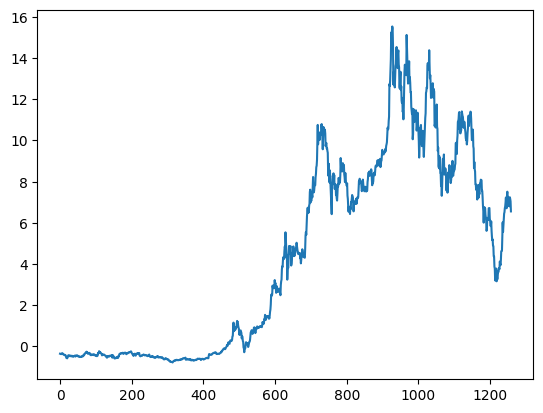

In [13]:
# Let's visualize this data
plt.plot(closing_price_series);

### Create the dataset
Using the T past values to predict the next value.

#### Helper utils
* create_dataset
* BaselineModel Class: 
Class will be called with train and test datasets generated on this section. 


In [14]:
def create_dataset(series, model_type="baseline"):
  """
  Creates the dataset needed with the correct shape for either the baseline
  model or a RNN.
  """

  # We will be converting time series into a supervised learning dataset.
  X = []
  Y = []
  T = 10  # Past values

  # Let's generate predictions, excluding the last value of the close price series.
  for t in range(len(series) - T):
    x = series[t:t+T]
    y = series[t+T]
    X.append(x) # previous
    Y.append(y) # prediction (next value)

  # Now we convert the values to numpy arrays.
  if (model_type != "baseline"):
        X = np.array(X).reshape(-1, T, 1)
  else:
    X = np.array(X).reshape(-1,T)
  
  Y = np.array(Y)

  return X, Y


In [15]:
# The BaselineModel is then simple. The data (X) is of size NxT, where N=len(X) and T is the past values.
# Each row is a sample and each column is a sequence of values of the time series input.
# All we have to do is retrieve the last value
class BaselineModel:
  def predict(self, X):
    # Return the last value for each sequence passed in as an argument.
    print(X[:, -1]) 
    return X[:, -1]


In [16]:
X, Y = create_dataset(closing_price_series)
print(f'Shape of X: {X.shape}\nShape of Y: {Y.shape}')

Shape of X: (1249, 10)
Shape of Y: (1249,)


### Split into train and test data

In [17]:
N = len(X)  # Stores the total size of the input

# train_test_split selects values at random, which would generate values that 
# are dispersed. Not good for our time series data. 
# Remember we can only predict using values from the past. 
Xtrain, Ytrain = X[:-N//2], Y[:-N//2] # Second half 
Xtest, Ytest = X[-N//2:], Y[-N//2:]   # First half

### Get the predictions

In [18]:
# Instantiate the model
baseline_model = BaselineModel()

# Generate the predicted data
Ptrain = baseline_model.predict(Xtrain)
Ptest = baseline_model.predict(Xtest)

[-0.37824629 -0.38986014 -0.41114751 -0.41937277 -0.40303152 -0.42333509
 -0.44399396 -0.43677976 -0.50509614 -0.56357497 -0.54075724 -0.57805798
 -0.53693158 -0.48389075 -0.43257153 -0.45011514 -0.4764579  -0.43535876
 -0.4456609  -0.4643796  -0.44727315 -0.4722223  -0.48184126 -0.46637441
 -0.44798367 -0.47487299 -0.49364633 -0.49340039 -0.50096982 -0.48788041
 -0.4643796  -0.46487151 -0.44842086 -0.44505966 -0.49069506 -0.46435221
 -0.44063276 -0.44281899 -0.42948357 -0.43448433 -0.44530564 -0.47014551
 -0.49143288 -0.48514775 -0.49044908 -0.51154523 -0.49058574 -0.51649131
 -0.50539668 -0.50873058 -0.50599792 -0.49258055 -0.47082865 -0.4899299
 -0.47055541 -0.45711071 -0.4724409  -0.39491554 -0.40423388 -0.39994355
 -0.36048409 -0.33132659 -0.32583404 -0.29047343 -0.28924374 -0.25464833
 -0.30460131 -0.27817644 -0.31837381 -0.35630304 -0.35799736 -0.3334308
 -0.32659911 -0.3117608  -0.33083476 -0.3523681  -0.41852559 -0.42317118
 -0.42388169 -0.39762087 -0.38679955 -0.39639113 -0.4

### Calculate the MAE

In [19]:
# Our data was scaled with the StandardScaler, we need to inverse_transform to calculate the MAE correctly. We convert the data back to the correct range.
Ytrain2 = scaler_model.inverse_transform(Ytrain.reshape(-1,1)).flatten()
Ytest2 = scaler_model.inverse_transform(Ytest.reshape(-1,1)).flatten()
Ptrain2 = scaler_model.inverse_transform(Ptrain.reshape(-1,1)).flatten()
Ptest2 = scaler_model.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [20]:
# Now we can calculate the MAE regression loss
print(f'Baseline Model:')
print("Train MAE:", mae(Ytrain2, Ptrain2))
print("Test MAE:", mae(Ytest2, Ptest2))

Baseline Model:
Train MAE: 1.0834358573717946
Test MAE: 7.107424646399999


Interestingly enough the model didn't do as well on the train data but it did worse on the test. 

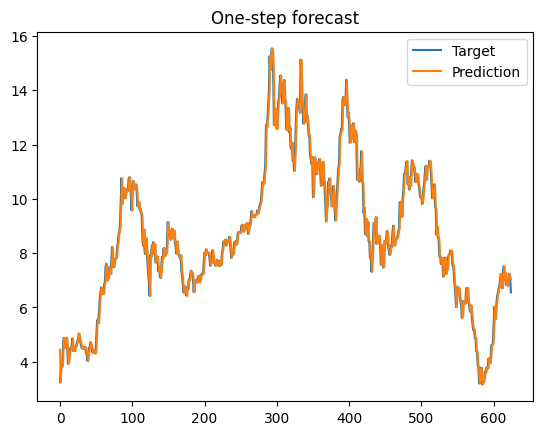

In [21]:
# Let's visualize the "one-step" forecast here.
plt.plot(Ytest, label='Target');
plt.plot(Ptest, label='Prediction');
plt.legend();
plt.title("One-step forecast");

The results look very accurate (almost as if the model was overfitted) but that is because this model hasn't learned the patterns on the data, it just added the last value. We can zoom-in a bit more to see that this is the case for all the trends.  Really not a good model for prediction.


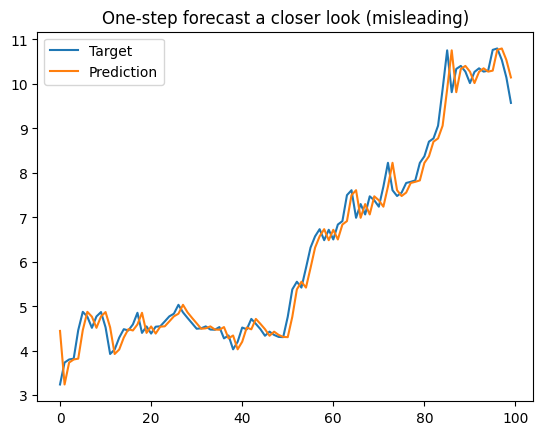

In [22]:
plt.plot(Ytest[0:100], label='Target');
plt.plot(Ptest[0:100], label='Prediction');
plt.legend();
plt.title("One-step forecast a closer look (misleading)");

In [23]:
# Let's try a different approach, selecting a slice from the ndarray and using 
# the baselinemodel to predict the next value. This example illustrates that the
# baseline model is not predicting it's just adding the last value of the input
# series as the next prediction.
prediction = []
input_value = Xtest[0] 

# Look back 10 values.
T = 10

while len(prediction) < len(Ytest):
  # It is the exact same value, over and over.
  p = baseline_model.predict(input_value.reshape(1, T))[0]
  prediction.append(p)

  # Update the input value with the latest prediction
  input_value = np.roll(input_value,-1) # Roll value one cell to the left.
  input_value[-1] = p

[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]
[4.44762219]

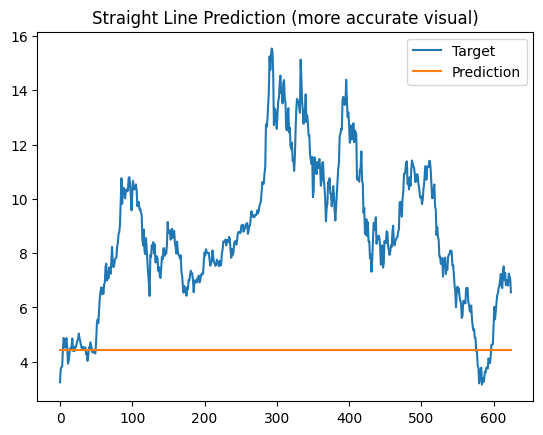

In [24]:
# Visualize the results
plt.plot(Ytest, label="Target");
plt.plot(prediction, label="Prediction");
plt.legend();
plt.title("Straight Line Prediction (more accurate visual)");

## Evaluating Other Models for Prediction

### LSTM

In [25]:
# Creates the dataset.
# We will attempt to predict the next value using the past 10 values.
X1, Y1 = create_dataset(closing_price_series, model_type="lstm")
print(f'Shape of X: {X1.shape}\nShape of Y: {Y1.shape}')

Shape of X: (1249, 10, 1)
Shape of Y: (1249,)


In [26]:
# Stores the total size of the input.
N = len(X1)  
# Model will look 10 days back to predict the next day.
look_back = 10  

# Data split into train and test (as before).
Xtrain, Ytrain = X1[:-N//2], Y1[:-N//2] # Second half 
Xtest, Ytest = X1[-N//2:], Y1[-N//2:]   # First half

In [27]:
# Instantiate the model - autoregressive RNN model.
inputs = Input(shape=(look_back, 1))
#x = LSTM(5)(inputs)
# Multiple LSTMs
x = LSTM(5, return_sequences=True)(inputs)
x = LSTM(5, return_sequences=True)(x)
x = LSTM(5)(x)

outputs = Dense(1)(x)
model = Model(inputs, outputs)

In [28]:
# Compile the model.
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [29]:
# Train the model 
rnn_trained = model.fit(Xtrain, Ytrain, epochs=80,
                        validation_data=(Xtest, Ytest))

Epoch 1/80
20/20 [==============================] - 13s 161ms/step - loss: 0.6695 - val_loss: 51.4238
Epoch 2/80
20/20 [==============================] - 1s 29ms/step - loss: 0.3101 - val_loss: 50.0832
Epoch 3/80
20/20 [==============================] - 1s 25ms/step - loss: 0.1588 - val_loss: 37.7856
Epoch 4/80
20/20 [==============================] - 1s 32ms/step - loss: 0.0934 - val_loss: 32.8815
Epoch 5/80
20/20 [==============================] - 0s 25ms/step - loss: 0.0600 - val_loss: 30.4209
Epoch 6/80
20/20 [==============================] - 1s 27ms/step - loss: 0.0532 - val_loss: 28.4470
Epoch 7/80
20/20 [==============================] - 1s 30ms/step - loss: 0.0692 - val_loss: 27.0006
Epoch 8/80
20/20 [==============================] - 0s 23ms/step - loss: 0.0538 - val_loss: 27.8284
Epoch 9/80
20/20 [==============================] - 1s 34ms/step - loss: 0.0411 - val_loss: 26.5888
Epoch 10/80
20/20 [==============================] - 1s 33ms/step - loss: 0.0356 - val_loss: 25.34

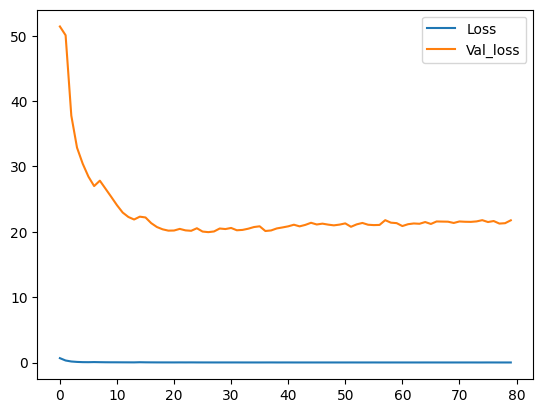

In [30]:
# Plot the loss per iteration
plt.plot(rnn_trained.history['loss'], label='Loss');
plt.plot(rnn_trained.history['val_loss'], label='Val_loss');
plt.legend();

Single LSTM results:
Loss per iteration decreased and the final loss stayed very close to zero the last two values were 0.0080 and 0.0083 but the validation loss was a bit high at 19.2691 and it stayed at that level.  

Multiple LSTM results:
Loss per iteration also decreased with a similar pattern as the single LSTM but with slightly higher validation loss staying predominantly at  ~21.

In [31]:
# We will attempt some predictions
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

20/20 [==============================] - 0s 3ms/step


In [32]:
# Let's get the data back to its original scale
Ytrain2 = scaler_model.inverse_transform(Ytrain.reshape(-1,1)).flatten()
Ytest2 = scaler_model.inverse_transform(Ytest.reshape(-1,1)).flatten()
Ptrain2 = scaler_model.inverse_transform(Ptrain.reshape(-1,1)).flatten()
Ptest2 = scaler_model.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [33]:
# Let's see how the MAE differs from the baseline
print(f'LSTM Model:')
print("Train MAE:", mae(Ytrain2, Ptrain2))
print("Test MAE:", mae(Ytest2, Ptest2))

LSTM Model:
Train MAE: 1.3457314842625154
Test MAE: 96.66472707405079


Well, the MAE for the validation set is definetly higher than expected. Performing worse than the baseline.

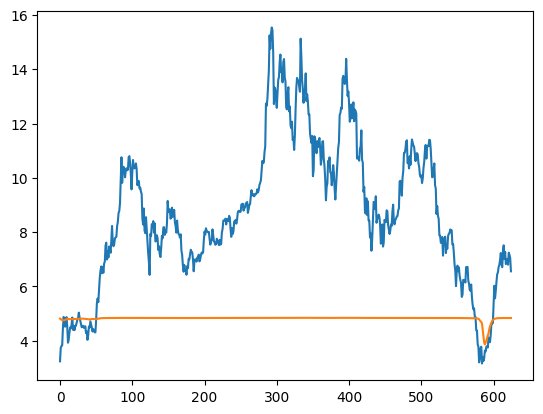

In [34]:
# Let's plot the one-step forecast (like we did before)
plt.plot(Ytest, label='Target')
plt.plot(Ptest, label='Prediction')

Definitely performed very bad, especially when attempting to hit the higher values. This could be because the training set may have not included those high values. [Differencing](https://otexts.com/fpp2/stationarity.html#differencing) could be useful here to eliminate (or reduce) trend and seasonality.

One lesson learned is that one-step prediction on stock prices is very misleading and a higher order model (like an RNN) is not necessarily better at prediction.  Let's explore now if we can do better at predicting if a stock would go up or down instead of just focusing on the price.

# Binary Classification
Exploring if we can predict whether the stock return is positive or negative.

In [35]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-02,21.798668,22.348000,21.531334,22.341333,22.341333,76392000
1,2018-03-05,22.159332,22.516666,21.952667,22.223333,22.223333,57357000
2,2018-03-06,22.250000,22.424667,21.802000,21.879999,21.879999,64285500
3,2018-03-07,21.695999,22.166668,21.449333,22.153334,22.153334,75109500
4,2018-03-08,22.190666,22.219999,21.751333,21.940001,21.940001,53493000


In [36]:
# Calculate the returns by shifting the data (everything up by 1)
df['PrevClose'] = df['Close'].shift(1) 

In [37]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose
0,2018-03-02,21.798668,22.348000,21.531334,22.341333,22.341333,76392000,NaN
1,2018-03-05,22.159332,22.516666,21.952667,22.223333,22.223333,57357000,22.341333
2,2018-03-06,22.250000,22.424667,21.802000,21.879999,21.879999,64285500,22.223333
3,2018-03-07,21.695999,22.166668,21.449333,22.153334,22.153334,75109500,21.879999
4,2018-03-08,22.190666,22.219999,21.751333,21.940001,21.940001,53493000,22.153334


We can see that entry 0 now has a NaN value as the previous close value due to the 1-value shifting.  This shouldn't present a problem as we will see in the next steps. To predict the return we will be looking back at N previous values (i.e. 10), so we won't really use that value to make the majority of the predictions.

In [39]:
# Let's calculate the stock return. The formula to calculate it is as follows:
# Return (R) = Final Price - Initial Price / Initial Price. In our case this 
# translates to the following:
df['Return'] = (df['Close'] - df['PrevClose']) / df['PrevClose'] 

In [40]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PrevClose,Return
0,2018-03-02,21.798668,22.348000,21.531334,22.341333,22.341333,76392000,NaN,NaN
1,2018-03-05,22.159332,22.516666,21.952667,22.223333,22.223333,57357000,22.341333,-0.005282
2,2018-03-06,22.250000,22.424667,21.802000,21.879999,21.879999,64285500,22.223333,-0.015449
3,2018-03-07,21.695999,22.166668,21.449333,22.153334,22.153334,75109500,21.879999,0.012492
4,2018-03-08,22.190666,22.219999,21.751333,21.940001,21.940001,53493000,22.153334,-0.009630


In [42]:
# For calculations let's convert the data into numpy arrays.
input_data = df[['Open','High','Low','Close', 'Volume']].values
targets = df['Return'].values

In [82]:
input_data.size

6295

**OBSERVATION:** Because the volume and the price are in different ranges. This data will need to be normalized.

In [62]:
# Let's set the training at about 2/3's of the data set instead of half like 
# we did before.
split_percent=.67 

# Hyper-parameter
look_back=10 # We have been using 10 but we can expand to more or less. 

train_data=int((len(input_data) - look_back) * split_percent)

In [59]:
# Input Dimensionality
D = input_data.shape[1]
D

5

In [81]:
train_data

836

In [64]:
# Setting the first part of the input_data array as training data.
train_data_input=input_data[:train_data + look_back - 1]
train_data_input

array([[2.17986680e+01, 2.23480000e+01, 2.15313340e+01, 2.23413330e+01,
        7.63920000e+07],
       [2.21593320e+01, 2.25166660e+01, 2.19526670e+01, 2.22233330e+01,
        5.73570000e+07],
       [2.22500000e+01, 2.24246670e+01, 2.18020000e+01, 2.18799990e+01,
        6.42855000e+07],
       ...,
       [2.21423340e+02, 2.21899994e+02, 2.12773331e+02, 2.14883331e+02,
        5.63760000e+07],
       [2.09456665e+02, 2.18143326e+02, 2.06820007e+02, 2.17603333e+02,
        6.83199000e+07],
       [2.17726669e+02, 2.19636673e+02, 2.14896667e+02, 2.18983337e+02,
        5.44215000e+07]])

In [79]:
train_data_input.size

4225

In [67]:
# Scaling the data
# Instantiate the scaler model
scaler_model=StandardScaler()

# Train the model with the train data
scaler_model.fit(train_data_input)

# Standarize the whole data set
input_data=scaler_model.transform(input_data)

### Create Xtrain and Ytrain data

In [78]:
# Initializing a 3-D array with zeros with train_data layers,
# 10 rows and 5 columns
Xtrain=np.zeros((train_data, look_back, D))
Ytrain=np.zeros(train_data)

for t_data in range(train_data):
  Xtrain[t_data, :, :] = input_data[t_data:t_data+T]
  # Binary: true if > 0; false otherwise.
  Ytrain[t_data] = (targets[t_data+look_back] > 0) 


### Create Xtest and Ytest data

In [89]:
# For readibility creating a new var to hold the result of 
# input_data - look_back.
Ntrain_data = len(input_data) - look_back # = 1249
# Initialize the arrays with zeros like before
Xtest=np.zeros((Ntrain_data - train_data, look_back, D))
Ytest=np.zeros(Ntrain_data - train_data)

# We will be indexing here as we populate the data from input_data
# Ntrain_data - train_data = 413

# From zero to 413
for n in range(Ntrain_data - train_data):
  # starts at train_data value
  i = n + train_data
  # The comma selecting specific cols to assign data to from input_data
  Xtest[n, :, :] = input_data[i:i+look_back]
  Ytest[n] = (targets[i+look_back] > 0)

### Create the RNN model


In [96]:
# We'll use the functional API again.
inputs = Input(shape=(look_back, D))
features = LSTM(50)(inputs)
outputs = Dense(1, activation='sigmoid')(features)
rnn_model = Model(inputs=inputs, outputs=outputs)
rnn_model.compile(
    loss='binary_crossentropy', # This is classification so no mse.
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [97]:
inputs.shape

TensorShape([None, 10, 5])

In [98]:
inputs.dtype

tf.float32

In [99]:
features.shape

TensorShape([None, 50])

In [100]:
rnn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                11200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


### Training the RNN model

In [103]:
fit_rnn = rnn_model.fit(
    Xtrain, Ytrain,
    batch_size=32,
    epochs=300,
    validation_data=(Xtest, Ytest),
)

Epoch 1/300
27/27 [==============================] - 5s 27ms/step - loss: 0.6954 - accuracy: 0.5203 - val_loss: 0.6916 - val_accuracy: 0.5327
Epoch 2/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6998 - accuracy: 0.5179 - val_loss: 0.7012 - val_accuracy: 0.4673
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6956 - accuracy: 0.4988 - val_loss: 0.6910 - val_accuracy: 0.5327
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5203 - val_loss: 0.6916 - val_accuracy: 0.5327
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.4868 - val_loss: 0.6911 - val_accuracy: 0.5327
Epoch 6/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6939 - accuracy: 0.4964 - val_loss: 0.6929 - val_accuracy: 0.5327
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.5203 - val_loss: 0.6910 - val_accuracy: 0.5327
Epoch 8/300


### Plotting the loss

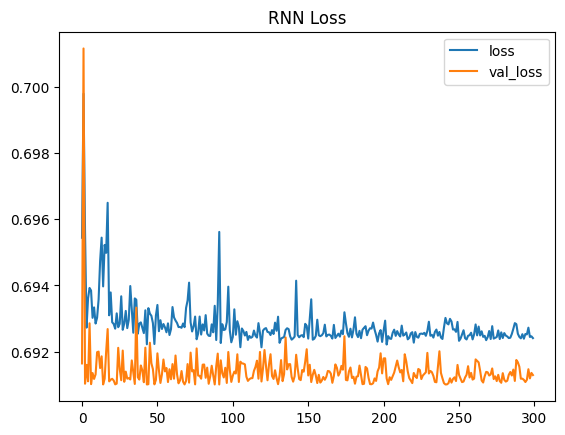

In [107]:
plt.plot(fit_rnn.history['loss'], label='loss');
plt.plot(fit_rnn.history['val_loss'], label='val_loss');
plt.title("RNN Loss")
plt.legend();

Both the train loss and validation loss follow a similar pattern they both start at a high level and then level off.
The train loss starts at a high of ~.700 then goes down and stays on a semi stedy pattern in between .693 - .694. On the other hand the validation loss start at a high above .700, goes down to .692 and levels off isolating to below .692 - .693 as well.




### Plotting Accuracy


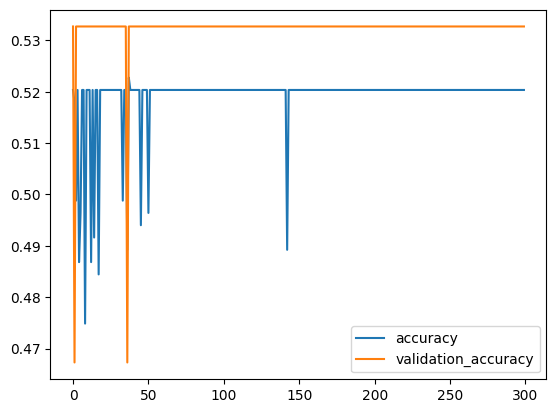

In [113]:
plt.plot(fit_rnn.history['accuracy'], label='accuracy');
plt.plot(fit_rnn.history['val_accuracy'], label='validation_accuracy');
plt.legend();

Training accuracy's trend initially isolated going down to below .48 and mostly staying at .52. The validation accuracy had a couple sharp momentary depressions going from .53 to below .47 but mostly staying flat at .53. For binary classification 50% tends to be the worse accuracy, so things are not looking good here - this just shows that the model is not better than random guessing. The LSTM doesn't seem to solve our challenge.

# Autoregressive Model

In [177]:
# Reloading the original data.
# Load the data for Tesla (stock symbol: TSLA)
df = pd.read_csv(f"{data_dir}/TSLA.csv", parse_dates=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-02,21.798668,22.348000,21.531334,22.341333,22.341333,76392000
1,2018-03-05,22.159332,22.516666,21.952667,22.223333,22.223333,57357000
2,2018-03-06,22.250000,22.424667,21.802000,21.879999,21.879999,64285500
3,2018-03-07,21.695999,22.166668,21.449333,22.153334,22.153334,75109500
4,2018-03-08,22.190666,22.219999,21.751333,21.940001,21.940001,53493000


In [178]:
# Getting the close price
close_price_series = df['Close'].values.reshape(-1,1)

In [179]:
# Normalize the data.
#split_percent=.5  

scaler_model = StandardScaler()
scaler_model.fit(close_price_series[:int(len(close_price_series) * split_percent)])
#scaler_model.fit(close_price_series[:len(close_price_series) // 2])
close_price_series = scaler_model.transform(close_price_series).flatten()


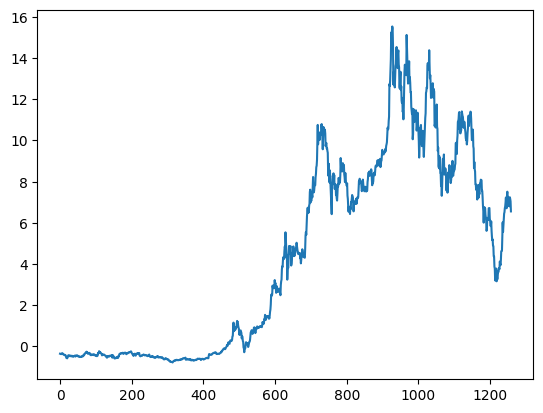

In [180]:
# Plotting the flatten data trends
plt.plot(close_price_series);
plt.show();

### Building the Dataset

In [181]:
look_back=10
X=[]
Y=[]

for i in range(len(close_price_series) - look_back):
  x=close_price_series[i:i+look_back]
  X.append(x)

  y=close_price_series[i+look_back]
  Y.append(y)

# Convert data to numpy arrays
X=np.array(X).reshape(-1, look_back)
Y=np.array(Y)
len_of_input=len(X)

In [182]:
X.shape

(1249, 10)

In [183]:
Y.shape

(1249,)

### Splitting Data into Train and Test


In [184]:
# Considered multiplying by the split_percent but for readability will 
# just divide instead. We would have to convert to int otherwise.
Xtrain, Ytrain=X[:-len_of_input // 2], Y[:-len_of_input // 2]
Xtest, Ytest=X[-len_of_input //2:], Y[-len_of_input // 2:]

### Instantiating and Training a LinearRegression Model


In [185]:
lr_model=LinearRegression()
lr_model.fit(Xtrain,Ytrain)

LinearRegression()

### Making Predictions

In [186]:
# Prediction train and test data
Ptrain=lr_model.predict(Xtrain)
Ptest=lr_model.predict(Xtest)

### Plotting the Forecasts

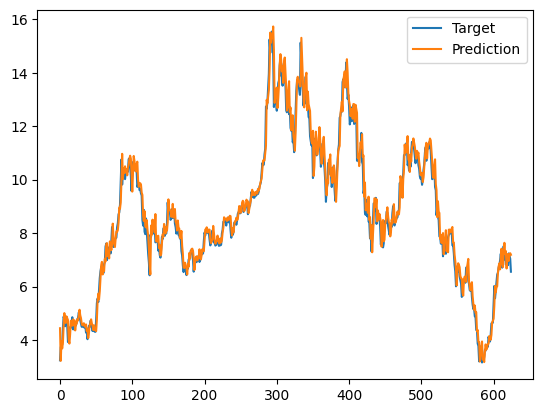

In [188]:
plt.plot(Ytest, label='Target');
plt.plot(Ptest, label='Prediction');
plt.legend();

As expected this is deceptively perfect at making predictions but we have learned what is happening here, from prior analysis, with the baseline model. It is only copying the previous value so the trends look perfect. However, this is not learning the patterns of the data.

In [189]:
# Now let's try a more realistic approach
predictions=[]
input=Xtest[0] # Initialize the input with the first entry in Xtest.

while (len(predictions) < len(Ytest)):
  # current prediction
  p=lr_model.predict(input.reshape(1,look_back))[0]
  predictions.append(p)

  # Update the input with the latest prediction
  input=np.roll(input,-1)
  input[-1]=p

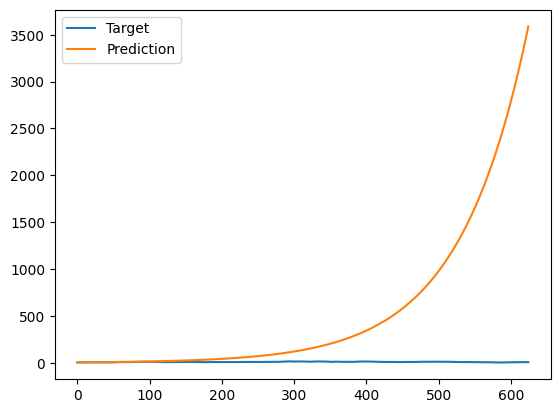

In [190]:
# Plotting the results
plt.plot(Ytest, label='Target');
plt.plot(predictions, label='Prediction');
plt.legend();

The prediction in this case goes up.

In [171]:
# Once again we inverse transform the data
Ytrain2 = scaler_model.inverse_transform(Ytrain.reshape(-1,1)).flatten()
Ytest2 = scaler_model.inverse_transform(Ytest.reshape(-1,1)).flatten()
Ptrain2 = scaler_model.inverse_transform(Ptrain.reshape(-1,1)).flatten()
Ptest2 = scaler_model.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [191]:
# Now we calculate the MAE
print(f'LR model train MAE: {mae(Ytrain2,Ptrain2)}')
print(f'LR model test MAE: {mae(Ytest2, Ptest2)}')

LR model train MAE: 1.1011559307200791
LR model test MAE: 7.7403841265286335


Interestingly the LR model does better than the RNN, which didn't seem to be the correct approach to predict stock trends. However, the baseline mode is still outperforming the LR in both train and test MAE results.

Baseline Model:
* Train MAE: 1.0834358573717946
* Test MAE: 7.107424646399999

In summary, we have learned that predicting stock prices using RNNs isn't realistic. This was an incredible surprise since many sources in the internet make it sound like they are the best method for stock prediction.

Next steps, will be to dive in deeper into the world of financial engineering and uncover other strategies to do algorithmic trading not just focusing on stock predictions for anything since the stock trends are influence by multiple other factors: emotions, general 